# Imports

In [13]:
import numpy as np
import random
import heapq
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Environment Setup

In [14]:
# Cell 2: Environment Definition

class DisasterZoneEnv:
    """
    A 2D grid environment for a drone exploring a disaster zone.

    Legend (internally stored as integers):
        0 -> Empty cell
        1 -> Obstacle
        2 -> Survivor
        3 -> Resource
    """

    def __init__(
        self,
        width=8,
        height=8,
        num_obstacles=5,
        num_survivors=3,
        num_resources=2,
        initial_energy=20,
        dynamic=False,
        predefined_grid=None,
        seed=None,  # Optional random seed
        recharge_amount=None # e.g. partial or full recharge
    ):
        self.width = width
        self.height = height
        self.num_obstacles = num_obstacles
        self.num_survivors = num_survivors
        self.num_resources = num_resources
        self.initial_energy = initial_energy
        self.energy = initial_energy
        self.dynamic = dynamic
        self.seed = seed
        self.recharge_amount = recharge_amount
        self.dynamic_changes = 0

        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        if predefined_grid is not None:
            self.reset_with_scenario(predefined_grid)
        else:
            self.reset()

    def reset(self):
        self.grid = np.zeros((self.height, self.width), dtype=int)

        # Place obstacles
        for _ in range(self.num_obstacles):
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 1

        # Place survivors
        for _ in range(self.num_survivors):
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 2

        # Place resources
        for _ in range(self.num_resources):
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 3

        # Random start for drone
        self.drone_x, self.drone_y = self._get_random_empty_cell()
        self.energy = self.initial_energy

    def reset_with_scenario(self, scenario):
        scenario = np.array(scenario, dtype=object)
        self.height, self.width = scenario.shape
        self.grid = np.zeros((self.height, self.width), dtype=int)

        drone_positions = []
        for i in range(self.height):
            for j in range(self.width):
                val = scenario[i, j]
                if val == 'D':
                    drone_positions.append((i, j))
                    self.grid[i, j] = 0
                else:
                    self.grid[i, j] = int(val)

        if len(drone_positions) != 1:
            raise ValueError("Scenario must contain exactly one 'D' for the drone's start.")
        self.drone_x, self.drone_y = drone_positions[0]
        self.energy = self.initial_energy

    def _get_random_empty_cell(self):
        while True:
            x = random.randint(0, self.height - 1)
            y = random.randint(0, self.width - 1)
            if self.grid[x, y] == 0:
                return x, y

    def apply_dynamic_changes(self, step_count):
        if not self.dynamic:
            return

        # Example: Add an obstacle every 5 steps
        if step_count > 0 and step_count % 5 == 0:
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 1
            self.dynamic_changes += 1

        # Example: Move survivors every 3 steps
        if step_count > 0 and step_count % 3 == 0:
            survivor_positions = [(xx, yy) for xx in range(self.height)
                                  for yy in range(self.width)
                                  if self.grid[xx, yy] == 2]
            for (sx, sy) in survivor_positions:
                self.grid[sx, sy] = 0
                nx, ny = self._get_random_empty_cell()
                self.grid[nx, ny] = 2

    def render(self):
        grid_copy = self.grid.astype(str)
        grid_copy[grid_copy == '0'] = '.'
        grid_copy[grid_copy == '1'] = '#'
        grid_copy[grid_copy == '2'] = 'S'
        grid_copy[grid_copy == '3'] = 'R'
        grid_copy[self.drone_x, self.drone_y] = 'D'

        for row in grid_copy:
            print(" ".join(row))
        print(f"Energy: {self.energy}\n")

# Agents classes

### Dijikstra agent

In [15]:
# Cell 3: Agents (Dijkstra)

class DijkstraAgent:
    """
    Pathfinding with Dijkstra.
    """

    def __init__(self, env):
        self.env = env
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0

    def dijkstra_search(self, grid, start, target):
        import heapq
        directions = [(-1,0), (1,0), (0,-1), (0,1)]
        pq = [(0, start)]
        distances = {start: 0}
        previous = {start: None}

        while pq:
            current_dist, current_pos = heapq.heappop(pq)
            if current_pos == target:
                path = []
                while current_pos is not None:
                    path.append(current_pos)
                    current_pos = previous[current_pos]
                path.reverse()
                return path, current_dist

            for dx, dy in directions:
                nx = current_pos[0] + dx
                ny = current_pos[1] + dy
                if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]:
                    if grid[nx, ny] != 1:  # Not an obstacle
                        new_dist = current_dist + 1
                        if (nx, ny) not in distances or new_dist < distances[(nx, ny)]:
                            distances[(nx, ny)] = new_dist
                            previous[(nx, ny)] = current_pos
                            heapq.heappush(pq, (new_dist, (nx, ny)))

        # If we exit loop, no path found
        return [], float('inf')

    def find_closest_target(self, target_type):
        start = (self.env.drone_x, self.env.drone_y)
        targets = [(x,y) for x in range(self.env.height)
                   for y in range(self.env.width)
                   if self.env.grid[x,y] == target_type]
        if not targets:
            return None, None, float('inf')

        best_path = None
        best_target = None
        best_dist = float('inf')
        for t in targets:
            path, dist = self.dijkstra_search(self.env.grid, start, t)
            if dist < best_dist:
                best_dist = dist
                best_path = path
                best_target = t
        return best_path, best_target, best_dist

    def execute(self):
        step_count = 0
        while self.env.energy > 0:
            # First look for survivors
            path, target_pos, _ = self.find_closest_target(2)
            if not path:
                # Then resources
                path, target_pos, _ = self.find_closest_target(3)
            if not path:
                print("No reachable targets. Done.")
                break

            # Move step by step
            for cell in path[1:]:
                self.env.drone_x, self.env.drone_y = cell
                self.steps_taken += 1
                step_count += 1

                # If dynamic
                if self.env.dynamic:
                    self.env.apply_dynamic_changes(step_count)

                # Drone uses 1 energy per step
                self.env.energy -= 1
                if self.env.energy <= 0:
                    break

            # If we actually reached a target
            if target_pos:
                val = self.env.grid[target_pos[0], target_pos[1]]
                if val == 2:
                    self.survivors_rescued += 1
                elif val == 3:
                    self.resources_collected += 1
                # Mark that cell empty
                self.env.grid[target_pos[0], target_pos[1]] = 0


### A* agent

In [16]:
class AStarAgent:
    """
    An agent that uses the A* search algorithm to navigate the DisasterZoneEnv.
    """

    def __init__(self, env):
        self.env = env
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0

    def heuristic(self, a, b):
        """
        Heuristic function for A* (Manhattan distance).
        :param a: (x1, y1) current cell
        :param b: (x2, y2) target cell
        :return: Manhattan distance between a and b
        """
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def a_star_search(self, grid, start, goal):
        """
        A* search for shortest path from start to goal.
        :param grid: the environment's grid (2D numpy array)
        :param start: (x, y) start coordinates
        :param goal: (x, y) goal coordinates
        :return: (path, cost) => path is a list of (x, y), cost is total steps
        """
        import heapq
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        
        # g_cost holds the actual distance from start to each node
        g_cost = {start: 0}
        # f_cost holds the estimated total cost from start -> goal
        f_cost = {start: self.heuristic(start, goal)}

        # Priority queue holds tuples (f_cost, (x, y))
        open_set = [(f_cost[start], start)]
        came_from = {start: None}  # To reconstruct path later

        while open_set:
            _, current = heapq.heappop(open_set)

            if current == goal:
                # Reconstruct path
                path = []
                while current is not None:
                    path.append(current)
                    current = came_from[current]
                path.reverse()
                return path, g_cost[goal]

            # Explore neighbors
            for dx, dy in directions:
                nx, ny = current[0] + dx, current[1] + dy
                if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]:
                    if grid[nx, ny] != 1:  # Not an obstacle
                        tentative_g = g_cost[current] + 1
                        if (nx, ny) not in g_cost or tentative_g < g_cost[(nx, ny)]:
                            g_cost[(nx, ny)] = tentative_g
                            f_cost[(nx, ny)] = tentative_g + self.heuristic((nx, ny), goal)
                            came_from[(nx, ny)] = current
                            # Push into priority queue
                            heapq.heappush(open_set, (f_cost[(nx, ny)], (nx, ny)))

        # If no path found
        return [], float('inf')

    def find_closest_target(self, target_type):
        """
        Find the path to the closest cell with grid value == target_type (2=Survivor, 3=Resource).
        :param target_type: int representing the type we're seeking in the environment.
        :return: (path, target_position, distance)
        """
        start = (self.env.drone_x, self.env.drone_y)
        targets = [(x, y) for x in range(self.env.height)
                   for y in range(self.env.width)
                   if self.env.grid[x, y] == target_type]

        if not targets:
            print(f"No targets of type {target_type} found.")
            return None, None, float('inf')

        best_path = None
        best_target = None
        best_dist = float('inf')

        for t in targets:
            path, dist = self.a_star_search(self.env.grid, start, t)
            if dist < best_dist:
                best_dist = dist
                best_path = path
                best_target = t

        print(f"Closest target of type {target_type} is {best_target} at distance {best_dist}")
        return best_path, best_target, best_dist

    def execute(self):
        """
        Main loop for the A* agent:
        - Repeatedly find nearest survivor, if none, nearest resource.
        - Follow the path step by step, applying dynamic changes if necessary.
        - Stop when no path or out of energy.
        """
        step_count = 0
        while self.env.energy > 0:
            # 1) Try survivors
            path, target_pos, _ = self.find_closest_target(2)
            if not path:
                # 2) If no survivors, look for resources
                path, target_pos, _ = self.find_closest_target(3)

            if not path:
                print("No reachable targets. Stopping.")
                break

            # Move along the path, ignoring path[0] since that's the current position
            for cell in path[1:]:
                self.env.drone_x, self.env.drone_y = cell
                self.steps_taken += 1
                step_count += 1

                # If environment is dynamic, apply changes
                if self.env.dynamic:
                    self.env.apply_dynamic_changes(step_count)

                # Use energy
                self.env.energy -= 1
                if self.env.energy <= 0:
                    break

            # Check if we actually reached a target
            if target_pos:
                # If the environment cell is still the same type (it might have changed if dynamic)
                val = self.env.grid[target_pos[0], target_pos[1]]
                if val == 2:
                    self.survivors_rescued += 1
                elif val == 3:
                    self.resources_collected += 1
                # Mark it empty
                self.env.grid[target_pos[0], target_pos[1]] = 0


### Q-learning agent

# Static scenrios to test on all agents

In [17]:
# Cell 4: Scenarios Dictionary

SCENARIOS_DICT = {
    "Scenario_1": {
        "name": "Simple Layout",
        "grid": np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 2, 0, 1, 0, 0, 3, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [3, 0, 0, 0, 0, 0, 0, 'D']
        ], dtype=object),
        "dynamic": False,
        "description": "Minimal obstacles, static environment"
    },
    "Scenario_2": {
        "name": "Obstacle Maze",
        "grid": np.array([
            [0, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 2, 1, 0, 1, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 1, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 3],
            [0, 1, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 0, 2, 0],
            ['D', 1, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "More complex layout"
    },
    "Scenario_3": {
        "name": "Dynamic Mixed Layout",
        "grid": np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 3, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 2, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 3, 0, 0, 0, 0],
            ['D', 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "Dynamic environment with obstacles and survivors moving"
    }
    # Add more scenarios (Scenario_4, 5, 6, etc.) similarly
}


# Testing class for all agents

In [18]:
# Cell 5: Tester

class Tester:
    """
    Runs multiple agents on multiple scenarios, collects metrics.
    """

    def __init__(self, agent_classes, scenarios_dict, env_params=None):
        self.agent_classes = agent_classes
        self.scenarios_dict = scenarios_dict
        self.env_params = env_params if env_params else {}
        self.results = []

    def run_all_scenarios(self):
        for scenario_id, scenario_info in self.scenarios_dict.items():
            scenario_grid = scenario_info["grid"]
            scenario_name = scenario_info.get("name", scenario_id)
            scenario_dynamic = scenario_info.get("dynamic", False)
            scenario_desc = scenario_info.get("description", "")

            # Merge scenario-level dynamic with global env_params
            param_dynamic = scenario_dynamic or self.env_params.get("dynamic", False)
            param_initial_energy = scenario_info.get("initial_energy", self.env_params.get("initial_energy", 20))

            # Potentially handle other overrides if you want: e.g. num_obstacles, seed, etc.

            for agent_class in self.agent_classes:
                # Create environment
                env = DisasterZoneEnv(
                    width=self.env_params.get("width", 8),
                    height=self.env_params.get("height", 8),
                    num_obstacles=self.env_params.get("num_obstacles", 5),
                    num_survivors=self.env_params.get("num_survivors", 3),
                    num_resources=self.env_params.get("num_resources", 2),
                    initial_energy=param_initial_energy,
                    dynamic=param_dynamic,
                    predefined_grid=scenario_grid,
                    seed=self.env_params.get("seed", None),
                    recharge_amount=self.env_params.get("recharge_amount", None)
                )

                agent = agent_class(env)

                start_time = time.time()
                agent.execute()
                end_time = time.time()

                comp_time = end_time - start_time

                self.results.append({
                    "Scenario ID": scenario_id,
                    "Scenario Name": scenario_name,
                    "Description": scenario_desc,
                    "Is Dynamic": param_dynamic,
                    "Agent Name": agent_class.__name__,
                    "Steps Taken": getattr(agent, "steps_taken", None),
                    "Survivors Rescued": getattr(agent, "survivors_rescued", None),
                    "Resources Collected": getattr(agent, "resources_collected", None),
                    "Energy Used": param_initial_energy - env.energy,
                    "Computation Time (s)": comp_time
                })

    def get_results_df(self):
        return pd.DataFrame(self.results)

    def save_results(self, filename="results.csv"):
        df = pd.DataFrame(self.results)
        df.to_csv(filename, index=False)
        print(f"Results saved to {filename}")


# Testing the code and agents

In [19]:
# Suppose you have your DijkstraAgent and AStarAgent classes defined already...

agent_list = [DijkstraAgent, AStarAgent]  # Now we test both

env_params = {
    "width": 8,
    "height": 8,
    "num_obstacles": 5,
    "num_survivors": 3,
    "num_resources": 2,
    "initial_energy": 20,
    "dynamic": False,
    "seed": 42
}

tester = Tester(agent_classes=agent_list, scenarios_dict=SCENARIOS_DICT, env_params=env_params)
tester.run_all_scenarios()
df_results = tester.get_results_df()
print(df_results)

Closest target of type 2 is (6, 5) at distance 3
Closest target of type 2 is (2, 1) at distance 8
No targets of type 2 found.
Closest target of type 3 is (7, 0) at distance 6
No targets of type 2 found.
Closest target of type 3 is (2, 6) at distance 11
Closest target of type 2 is (1, 2) at distance 8
Closest target of type 2 is (6, 6) at distance 9
No targets of type 2 found.
Closest target of type 3 is (4, 7) at distance 3
Closest target of type 2 is (1, 1) at distance 7
Closest target of type 2 is (6, 0) at distance 6
Closest target of type 2 is (0, 3) at distance 9
  Scenario ID         Scenario Name  \
0  Scenario_1         Simple Layout   
1  Scenario_1         Simple Layout   
2  Scenario_2         Obstacle Maze   
3  Scenario_2         Obstacle Maze   
4  Scenario_3  Dynamic Mixed Layout   
5  Scenario_3  Dynamic Mixed Layout   

                                         Description  Is Dynamic  \
0              Minimal obstacles, static environment       False   
1              

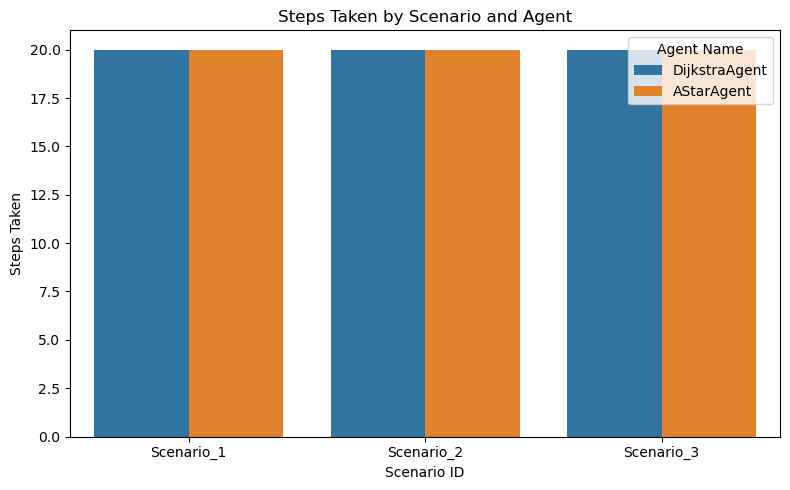

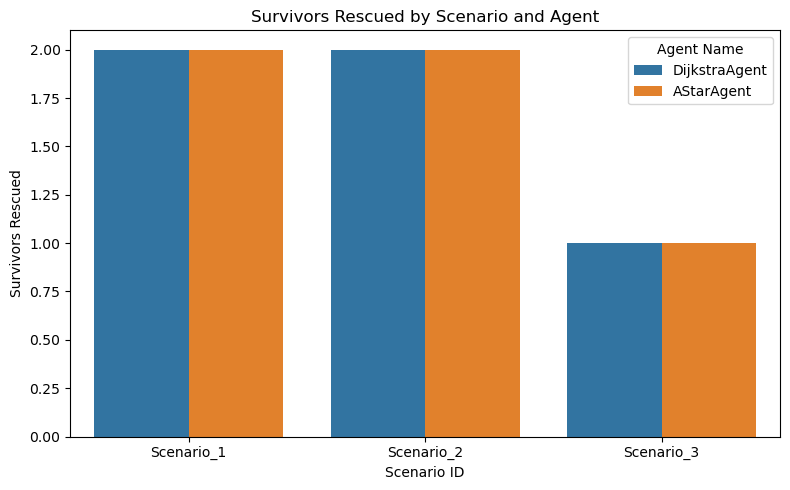

In [20]:
# Cell 7: Visualizations

# 1) Basic bar plot of Steps Taken per Scenario, grouped by Agent
plt.figure(figsize=(8,5))
sns.barplot(data=df_results, x="Scenario ID", y="Steps Taken", hue="Agent Name")
plt.title("Steps Taken by Scenario and Agent")
plt.tight_layout()
plt.show()

# 2) Survivors Rescued
plt.figure(figsize=(8,5))
sns.barplot(data=df_results, x="Scenario ID", y="Survivors Rescued", hue="Agent Name")
plt.title("Survivors Rescued by Scenario and Agent")
plt.tight_layout()
plt.show()

# If you have multiple dynamic scenarios, you can see performance differences, etc.
